In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
import rasterio
import rasterio.mask
from rasterio.features import rasterize
import geopandas as gpd
from rasterio.windows import Window
from IPython.display import display
from shapely.geometry import box, Polygon, MultiPolygon
import rasterio.windows as rio_windows
import matplotlib.pyplot as plt
import math

In [3]:
directories_to_process = [
    ('/datasets/rpartsey/satellite/planet/SNP_Planet_Scenes_2017_Spring_I', 'spring'),
    ('/datasets/rpartsey/satellite/planet/SNP_Planet_Scenes_2017_Spring_II', 'spring'),
    ('/datasets/rpartsey/satellite/planet/SNP_Planet_Scenes_2017_Summer_Autumn_I', 'summer-autumn')
]

base_dirs_df = pd.DataFrame(directories_to_process, columns=['base_dir', 'tag'])
base_dirs_df.head()

,base_dir,tag
0,/datasets/rpartsey/satellite/planet/SNP_Planet...,spring
1,/datasets/rpartsey/satellite/planet/SNP_Planet...,spring
2,/datasets/rpartsey/satellite/planet/SNP_Planet...,summer-autumn


In [4]:
dfs = []

for i, row in base_dirs_df.iterrows():
    df = pd.read_csv(os.path.join(row.base_dir, 'files.csv'), index_col=0)
    df['base_dir_id'] = i
    dfs.append(df)

files_df = pd.concat(dfs, axis=0, sort=False)
print(files_df.shape)
files_df.head()

(103, 6)


,image,udm_mask,shape_file,xml,json,base_dir_id
20170402_074845_0f17,20170402_074845_0f17_3B_AnalyticMS.tif,20170402_074845_0f17_3B_AnalyticMS_DN_udm.tif,20170402_074845_0f17.shp,20170402_074845_0f17_3B_AnalyticMS_metadata.xml,20170402_074845_0f17_metadata.json,0
20170406_074822_1034,20170406_074822_1034_3B_AnalyticMS.tif,20170406_074822_1034_3B_AnalyticMS_DN_udm.tif,20170406_074822_1034.shp,20170406_074822_1034_3B_AnalyticMS_metadata.xml,20170406_074822_1034_metadata.json,0
20170330_075419_0e2f,20170330_075419_0e2f_3B_AnalyticMS.tif,20170330_075419_0e2f_3B_AnalyticMS_DN_udm.tif,20170330_075419_0e2f.shp,20170330_075419_0e2f_3B_AnalyticMS_metadata.xml,20170330_075419_0e2f_metadata.json,0
20170311_075415_0e0f,20170311_075415_0e0f_3B_AnalyticMS.tif,20170311_075415_0e0f_3B_AnalyticMS_DN_udm.tif,20170311_075415_0e0f.shp,20170311_075415_0e0f_3B_AnalyticMS_metadata.xml,20170311_075415_0e0f_metadata.json,0
20170311_075416_0e0f,20170311_075416_0e0f_3B_AnalyticMS.tif,20170311_075416_0e0f_3B_AnalyticMS_DN_udm.tif,20170311_075416_0e0f.shp,20170311_075416_0e0f_3B_AnalyticMS_metadata.xml,20170311_075416_0e0f_metadata.json,0


In [5]:
merged_df = pd.merge(base_dirs_df, files_df, how='inner', left_index=True, right_on='base_dir_id')
merged_df.tag.unique()

array(['spring', 'summer-autumn'], dtype=object)

In [6]:
merged_df['tag'] = merged_df['tag'].map(lambda tag: tag.replace('-', '_'))

In [7]:
merged_df.head(2)

,base_dir,tag,image,udm_mask,shape_file,xml,json,base_dir_id
20170402_074845_0f17,/datasets/rpartsey/satellite/planet/SNP_Planet...,spring,20170402_074845_0f17_3B_AnalyticMS.tif,20170402_074845_0f17_3B_AnalyticMS_DN_udm.tif,20170402_074845_0f17.shp,20170402_074845_0f17_3B_AnalyticMS_metadata.xml,20170402_074845_0f17_metadata.json,0
20170406_074822_1034,/datasets/rpartsey/satellite/planet/SNP_Planet...,spring,20170406_074822_1034_3B_AnalyticMS.tif,20170406_074822_1034_3B_AnalyticMS_DN_udm.tif,20170406_074822_1034.shp,20170406_074822_1034_3B_AnalyticMS_metadata.xml,20170406_074822_1034_metadata.json,0


In [ ]:
def plot_poly(polygon):
    fig, axs = plt.subplots()
    axs.set_aspect('equal', 'datalim')

    if isinstance(polygon, MultiPolygon):        
        for sub_polygon in polygon:
            xs, ys = sub_polygon.exterior.xy    
            axs.fill(xs, ys, alpha=0.5, fc='g', ec='none')
    else:
        xs, ys = polygon.exterior.xy    
        axs.fill(xs, ys, alpha=0.5, fc='g', ec='none')

    bbox = box(*polygon.bounds)
    xs, ys = bbox.exterior.xy
    axs.plot(xs, ys, alpha=0.5, c='b')

    xs, ys = bbox.centroid.xy
    axs.scatter(xs, ys, alpha=1, fc='k')

    plt.show()


In [ ]:

for polygon in shapes_df.geometry:
    plot_poly(polygon)

In [8]:
padding = 128
dest_dir_path = '/datasets/rpartsey/satellite/planet/smart_crop'

df = merged_df


for image_id, row in df.iterrows():
    tif_path = os.path.join(row.base_dir, image_id, row.image)
    shapefile_path = os.path.join(row.base_dir, image_id, row.shape_file)
    
    shapes_df = gpd.read_file(shapefile_path)
    shapes = shapes_df['geometry']
    break

In [9]:
shapes_df

,id,Dates,PlanetImg,FIRMSSourc,Note,Editor,geometry
0,0,2017-03-26,20170402_074845_0f17_tms.xml,_,None,Oleksandr Leiberiuk - 0051,"POLYGON ((34.97926 50.09216, 34.98053 50.09158..."
1,0,2017-03-27,20170411_075456_0e30_tms.xml,_,None,Oleksandr Leiberiuk - 0052,"POLYGON ((34.96350 50.10919, 34.96420 50.10948..."
2,0,2017-04-15,20170402_074845_0f17_tms.xml,"M6,V1",None,Oleksandr Leiberiuk - 0079,"POLYGON ((34.97092 50.06544, 34.97092 50.06491..."
3,0,2017-04-01,20170402_074845_0f17_tms.xml,_,None,Oleksandr Leiberiuk - 0081,"POLYGON ((34.97940 50.07008, 34.98014 50.06984..."


In [12]:
shapes_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
shapefile_path

'/datasets/rpartsey/satellite/planet/SNP_Planet_Scenes_2017_Spring_I/20170402_074845_0f17/20170402_074845_0f17.shp'

In [193]:
# NOTE SOME IMAGES MAY HAVE 3 CHANNELS

padding = 128
dest_dir_path = '/datasets/rpartsey/satellite/planet/smart_crop'

df = merged_df


for image_id, row in df.iterrows():
    tif_path = os.path.join(row.base_dir, image_id, row.image)
    shapefile_path = os.path.join(row.base_dir, image_id, row.shape_file)
    
    shapes_df = gpd.read_file(shapefile_path)
    shapes = shapes_df['geometry']
    
    with rasterio.open(tif_path) as src:
        shapes_crs = shapes.crs
        shapes = shapes.to_crs({'init': src.meta['crs']['init']})

        for poly_id, polygon in enumerate(shapes):
            # geo coordinates
            (minx, miny, maxx, maxy) = polygon.bounds
            
            top_left = (minx, maxy)
            bottom_right = (maxx, miny)
            
            # pixel coordinates
            minr, minc = src.index(*top_left)
            maxr, maxc = src.index(*bottom_right)
            
            # expanding bounding box by adding padding
            minr -= padding
            minc -= padding
            maxr += padding
            maxc += padding
            
            window = rio_windows.Window(
                col_off=minc,
                row_off=minr,
                width=maxc-minc,
                height=maxr-minr
            )
            
            dest_meta = src.meta.copy()
            dest_meta.update({
                'height': window.height,
                'width': window.width,
                'transform': rasterio.windows.transform(window, src.transform)
            })
            
            # store geojson mask
            dest_geojson_name = '{}-{}-{}.geojson'.format(row.tag, image_id, poly_id) 
            dest_geojson_path = os.path.join(dest_dir_path, 'geojsons', dest_geojson_name)
            
            gseries = gpd.GeoSeries([polygon])
            gseries.crs = shapes.crs
            gseries.to_crs(shapes_crs).to_file(dest_geojson_path, driver='GeoJSON')
            
            
            # srore cropped image
            dest_image_name = '{}-{}-{}.tif'.format(row.tag, image_id, poly_id) 
            dest_image_path = os.path.join(dest_dir_path, 'images', dest_image_name)
            
            with rasterio.open(dest_image_path, 'w', **dest_meta) as dest:
                dest.write(src.read(window=window, boundless=True, fill_value=0))
                

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

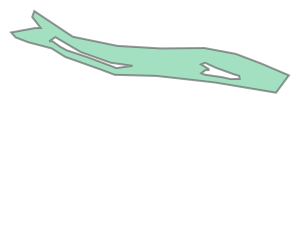

In [161]:
polygon

In [185]:
shapes.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 30°E to 36°E - by country
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [180]:
series = gpd.GeoSeries([polygon])

In [187]:
series.crs = shapes.crs

In [189]:
series.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 30°E to 36°E - by country
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [116]:
heights.max()

1234

In [117]:
widths.max()

1745

(array([55., 95., 50., 40., 40., 21.,  9., 12., 11.,  8.,  5.,  4.,  7.,
         2.,  3.,  4.,  0.,  0.,  1.,  1.,  0.,  1.,  2.,  1.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  18.        ,   53.76470588,   89.52941176,  125.29411765,
         161.05882353,  196.82352941,  232.58823529,  268.35294118,
         304.11764706,  339.88235294,  375.64705882,  411.41176471,
         447.17647059,  482.94117647,  518.70588235,  554.47058824,
         590.23529412,  626.        ,  661.76470588,  697.52941176,
         733.29411765,  769.05882353,  804.82352941,  840.58823529,
         876.35294118,  912.11764706,  947.88235294,  983.64705882,
        1019.41176471, 1055.17647059, 1090.94117647, 1126.70588235,
        1162.47058824, 1198.23529412, 1234.        ]),
 <a list of 34 Patch objects>)

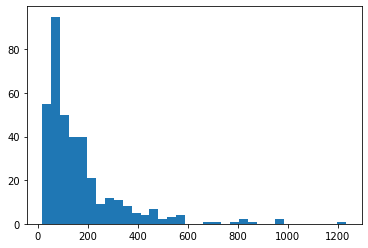

In [119]:
plt.hist(heights, bins='auto')

(array([73., 75., 54., 44., 36., 20., 16.,  9., 12.,  9.,  6.,  1.,  2.,
         3.,  1.,  3.,  0.,  0.,  0.,  0.,  2.,  0.,  2.,  1.,  2.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.]),
 array([  18.        ,   58.1627907 ,   98.3255814 ,  138.48837209,
         178.65116279,  218.81395349,  258.97674419,  299.13953488,
         339.30232558,  379.46511628,  419.62790698,  459.79069767,
         499.95348837,  540.11627907,  580.27906977,  620.44186047,
         660.60465116,  700.76744186,  740.93023256,  781.09302326,
         821.25581395,  861.41860465,  901.58139535,  941.74418605,
         981.90697674, 1022.06976744, 1062.23255814, 1102.39534884,
        1142.55813953, 1182.72093023, 1222.88372093, 1263.04651163,
        1303.20930233, 1343.37209302, 1383.53488372, 1423.69767442,
        1463.86046512, 1504.02325581, 1544.18604651, 1584.34883721,
        1624.51162791, 1664.6744186 , 1704.8372093 , 1745.        ]),
 

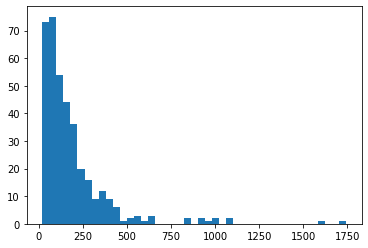

In [120]:
plt.hist(widths, bins='auto')

In [194]:
np.sum([55., 95., 50., 40., 40., 21.,  9., 12., 11.,  8.,  5.,  4.,  7.,
         2.,  3.,  4.,  0.,  0.,  1.,  1.,  0.,  1.,  2.,  1.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

375.0

In [39]:
shapes_df = pd.concat(dfs)

In [40]:
shapes_df.shape

(375, 7)

In [41]:
shapes = shapes_df['geometry']

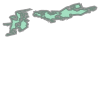

In [90]:
multi_poly = shapes.iloc[4]
multi_poly

In [91]:
multi_poly.

NotImplementedError: Multi-part geometries do not provide a coordinate sequence

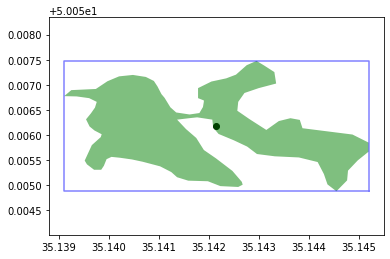

In [19]:
shapes_df.head()
shapes = shapes_df['geometry']
vertices = _build_polygon_vertices(**window.todict())  # vertices in pixel coordinates
#             poly = geometry.Polygon([src.xy(*v) for v in vertices])  # vertices in geo coordinates

,id,Dates,PlanetImg,FIRMSSourc,Note,Editor,geometry
0,0,2017-03-26,20170402_074845_0f17_tms.xml,_,None,Oleksandr Leiberiuk - 0051,"POLYGON ((34.97926 50.09216, 34.98053 50.09158..."
1,0,2017-03-27,20170411_075456_0e30_tms.xml,_,None,Oleksandr Leiberiuk - 0052,"POLYGON ((34.96350 50.10919, 34.96420 50.10948..."
2,0,2017-04-15,20170402_074845_0f17_tms.xml,"M6,V1",None,Oleksandr Leiberiuk - 0079,"POLYGON ((34.97092 50.06544, 34.97092 50.06491..."
3,0,2017-04-01,20170402_074845_0f17_tms.xml,_,None,Oleksandr Leiberiuk - 0081,"POLYGON ((34.97940 50.07008, 34.98014 50.06984..."
0,0,2017-04-03,20170406_074822_1034_tms.xml,"M6,V1",На снимке небольшая облачность,Oleksandr Leiberiuk - 0208,"MULTIPOLYGON (((34.99631 49.97869, 34.99660 49..."


In [ ]:
shapes_df = shapes_df.to_crs({'init': src.meta['crs']['init']})

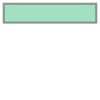

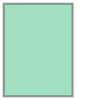

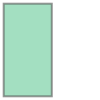

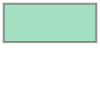

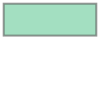

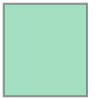

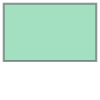

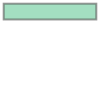

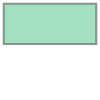

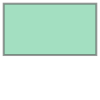

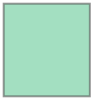

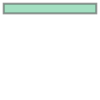

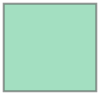

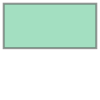

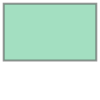

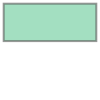

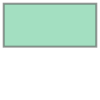

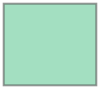

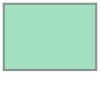

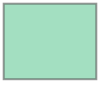

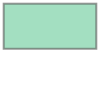

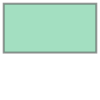

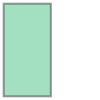

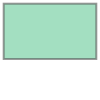

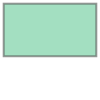

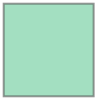

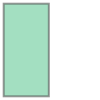

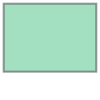

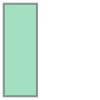

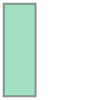

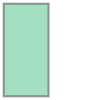

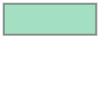

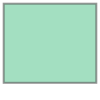

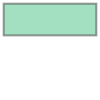

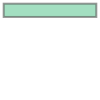

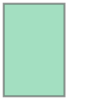

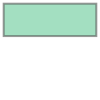

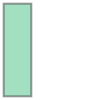

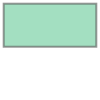

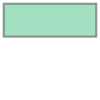

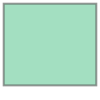

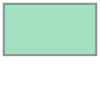

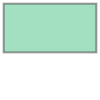

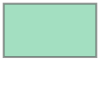

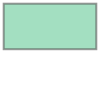

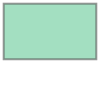

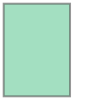

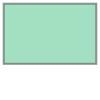

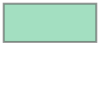

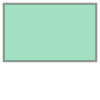

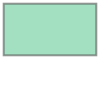

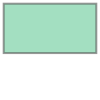

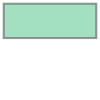

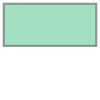

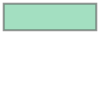

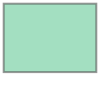

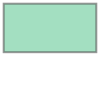

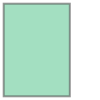

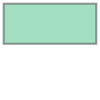

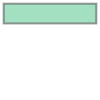

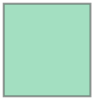

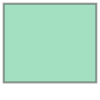

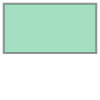

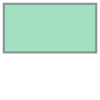

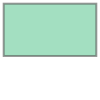

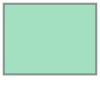

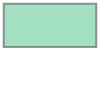

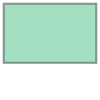

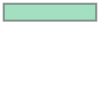

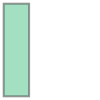

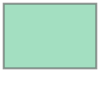

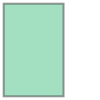

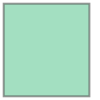

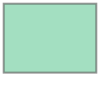

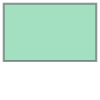

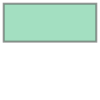

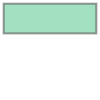

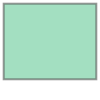

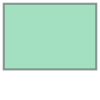

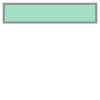

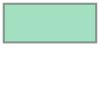

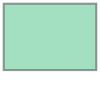

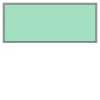

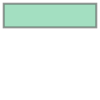

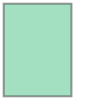

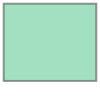

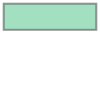

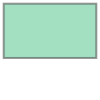

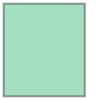

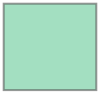

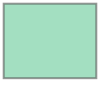

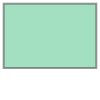

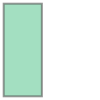

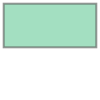

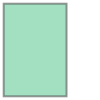

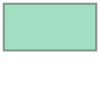

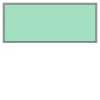

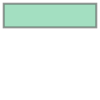

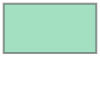

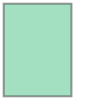

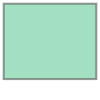

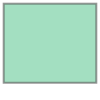

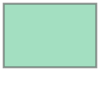

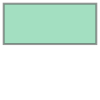

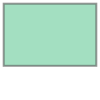

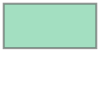

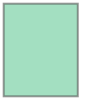

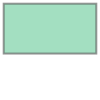

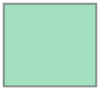

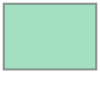

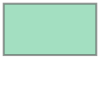

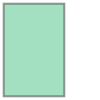

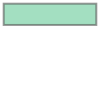

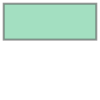

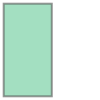

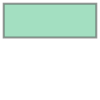

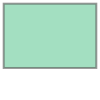

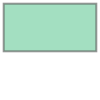

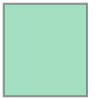

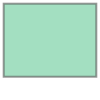

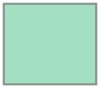

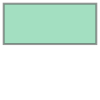

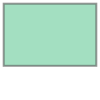

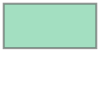

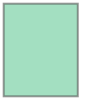

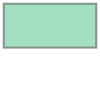

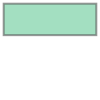

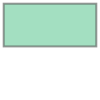

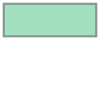

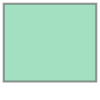

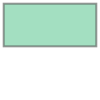

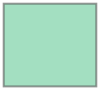

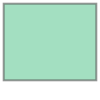

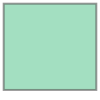

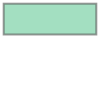

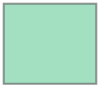

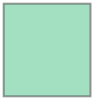

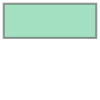

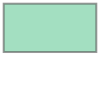

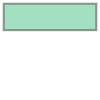

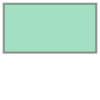

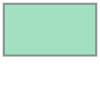

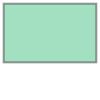

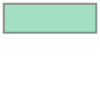

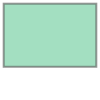

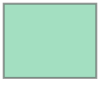

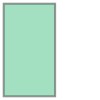

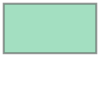

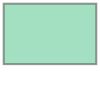

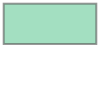

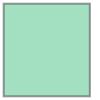

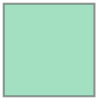

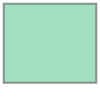

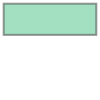

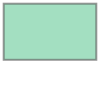

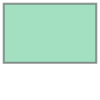

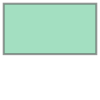

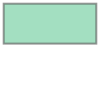

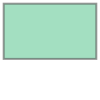

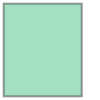

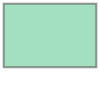

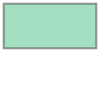

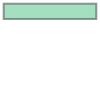

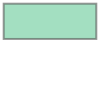

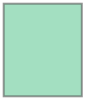

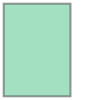

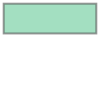

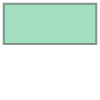

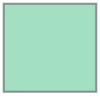

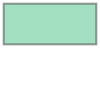

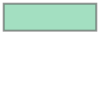

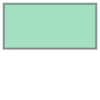

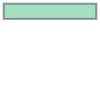

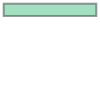

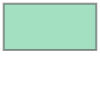

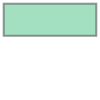

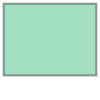

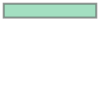

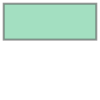

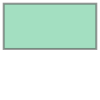

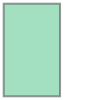

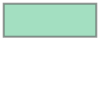

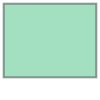

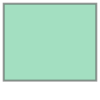

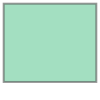

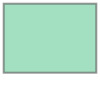

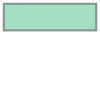

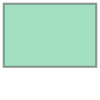

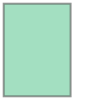

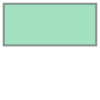

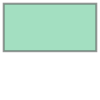

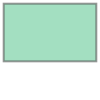

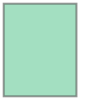

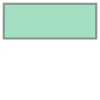

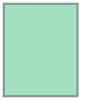

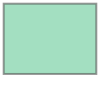

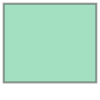

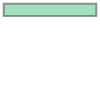

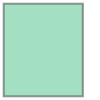

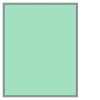

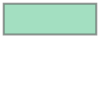

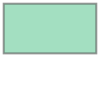

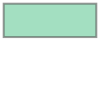

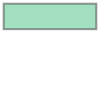

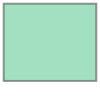

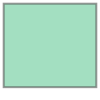

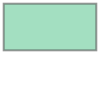

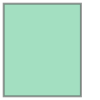

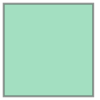

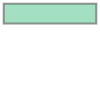

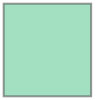

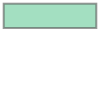

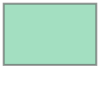

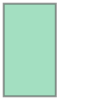

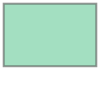

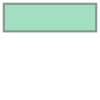

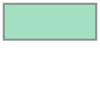

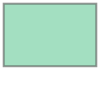

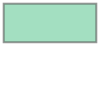

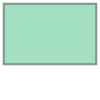

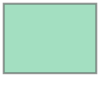

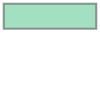

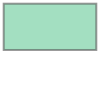

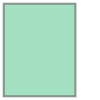

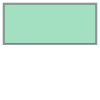

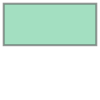

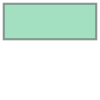

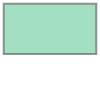

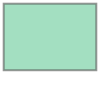

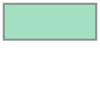

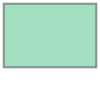

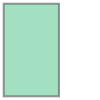

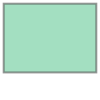

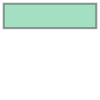

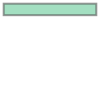

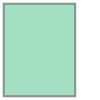

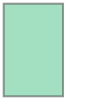

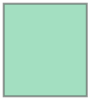

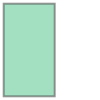

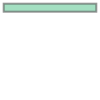

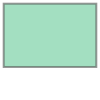

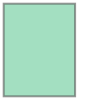

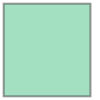

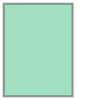

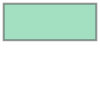

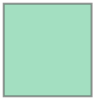

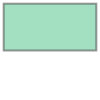

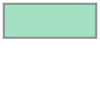

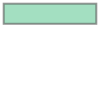

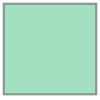

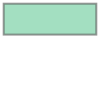

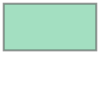

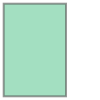

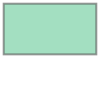

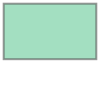

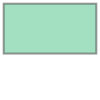

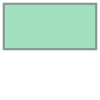

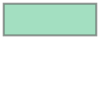

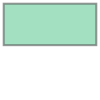

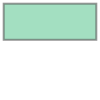

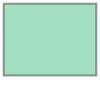

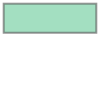

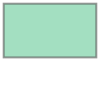

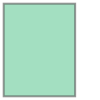

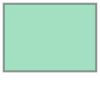

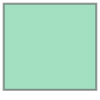

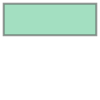

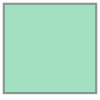

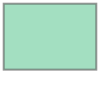

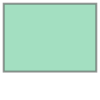

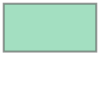

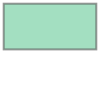

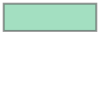

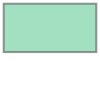

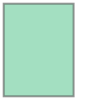

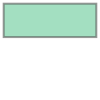

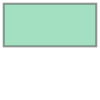

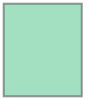

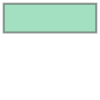

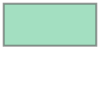

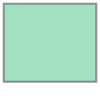

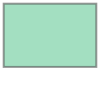

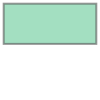

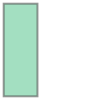

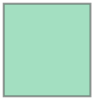

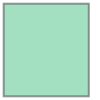

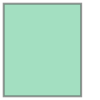

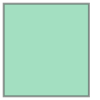

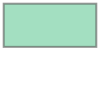

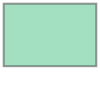

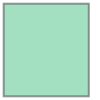

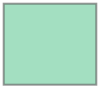

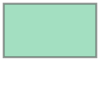

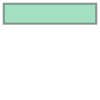

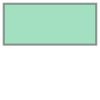

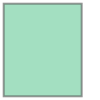

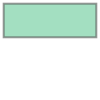

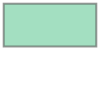

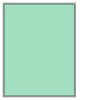

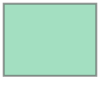

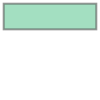

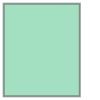

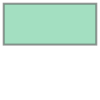

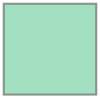

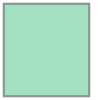

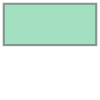

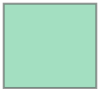

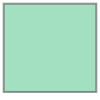

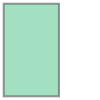

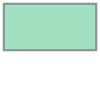

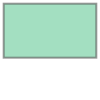

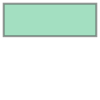

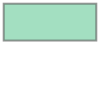

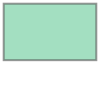

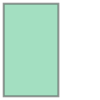

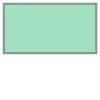

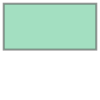

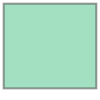

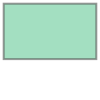

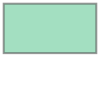

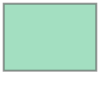

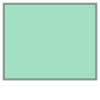

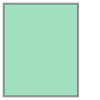

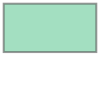

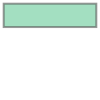

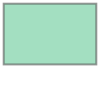

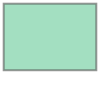

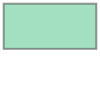

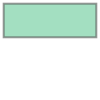

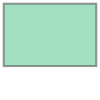

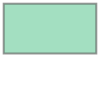

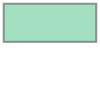

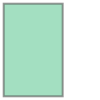

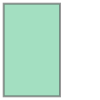

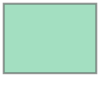

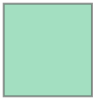

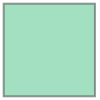

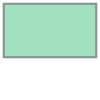

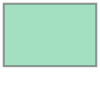

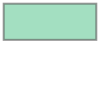

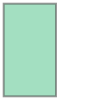

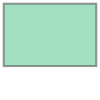

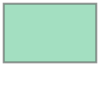

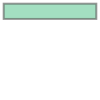

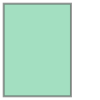

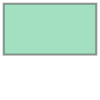

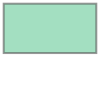

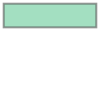

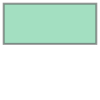

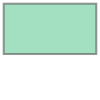

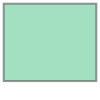

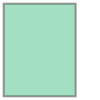

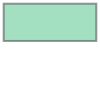

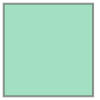

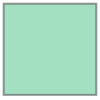

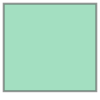

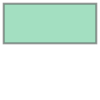

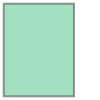

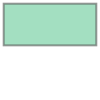

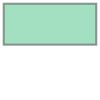

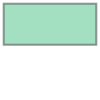

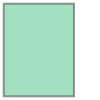

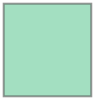

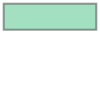

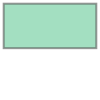

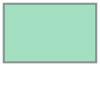

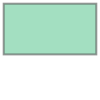

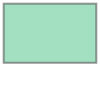

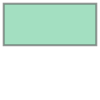

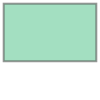

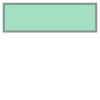

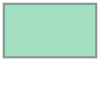

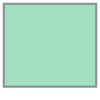

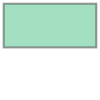

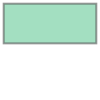

In [49]:
bbox= box(*polygon.bounds)

In [60]:
list(bbox.exterior.coords)

[(35.14518883632837, 50.054871874787466),
 (35.14518883632837, 50.05747559006998),
 (35.1391101894457, 50.05747559006998),
 (35.1391101894457, 50.054871874787466),
 (35.14518883632837, 50.054871874787466)]

In [38]:
row

base_dir       /datasets/rpartsey/satellite/planet/SNP_Planet...
tag                                                summer-autumn
image                     20171010_075826_0e14_3B_AnalyticMS.tif
udm_mask           20171010_075826_0e14_3B_AnalyticMS_DN_udm.tif
shape_file                              20171010_075826_0e14.shp
xml              20171010_075826_0e14_3B_AnalyticMS_metadata.xml
json                          20171010_075826_0e14_metadata.json
base_dir_id                                                    2
Name: 20171010_075826_0e14, dtype: object

In [41]:
tif_path = os.path.join(row.base_dir, row.name, row.image)
with rasterio.open(tif_path) as src:
    pass


In [61]:
src.bounds

BoundingBox(left=642480.0, bottom=5538795.0, right=669753.0, top=5552616.0)

## Generate masks

In [197]:
def create_shapes_bitmask(source_meta, shapes, mask_path):
    """
    Creates bit masks for shapes that intersect with raster image coordinates.

    :param source_meta: opened raster image
    :param shapes: iterable with shapes
    :param mask_file_name: file name to store mask on disk
    :return: None
    """
    im_size = (source_meta['height'], source_meta['width'])

    bitmask = rasterize(
        shapes=shapes,
        out_shape=im_size,
        transform=source_meta['transform']
    )

    bitmask_meta = {
        **source_meta,
        'dtype': rasterio.uint8,
        'count': 1
    }

    with rasterio.open(mask_path, 'w', **bitmask_meta) as dest:
        dest.write(bitmask, indexes=1)


images = sorted(glob('/datasets/rpartsey/satellite/planet/smart_crop/images/*.tif'))
geojsons = sorted(glob('/datasets/rpartsey/satellite/planet/smart_crop/geojsons/*.geojson'))
        
for image_path, shapes_path in zip(images, geojsons):
    mask_path = image_path.replace('images', 'masks')
    shapes_df = gpd.read_file(shapes_path)

    with rasterio.open(image_path) as src:
        shapes_df = shapes_df.to_crs({'init' : src.meta['crs']['init']})

        create_shapes_bitmask(
            source_meta=src.meta,
            shapes=shapes_df.geometry,
            mask_path=mask_path
        )

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/rpartsey/.virtualenvs/change_detection/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

In [48]:
# NOTE: run with caution, this will regenerate masks 

# generate_masks(merged_df)

In [6]:
df = pd.DataFrame()

In [7]:
df['image_path'] = sorted(glob('/datasets/rpartsey/satellite/planet/smart_crop/with_mask/images/*.tif'))
df['mask_path'] = sorted(glob('/datasets/rpartsey/satellite/planet/smart_crop/with_mask/masks/*.tif'))
df['bbox_path'] = sorted(glob('/datasets/rpartsey/satellite/planet/smart_crop/with_mask/bboxes/*.geojson'))
# df['geojson'] = sorted(glob('/datasets/rpartsey/satellite/planet/smart_crop/with_mask/geojsons/*.geojson'))

In [8]:
for _, (image, mask, bbox) in df.iterrows():
    assert os.path.exists(image) and os.path.exists(mask) and os.path.exists(bbox) # and os.path.exists(geojson)

In [6]:
df.shape

(372, 2)

In [9]:
df.to_csv('/datasets/rpartsey/satellite/planet/smart_crop/with_mask/files.csv', index=False)

In [12]:
df = pd.DataFrame()
df['image_path'] = sorted(glob('/datasets/rpartsey/satellite/planet/smart_crop/without_mask/images/*.tif'))
df['mask_path'] = sorted(glob('/datasets/rpartsey/satellite/planet/smart_crop/without_mask/masks/*.tif'))
df['bbox_path'] = sorted(glob('/datasets/rpartsey/satellite/planet/smart_crop/without_mask/bboxes/*.geojson'))
# df['geojson'] = sorted(glob('/datasets/rpartsey/satellite/planet/smart_crop/without_mask/geojsons/*.geojson'))

In [13]:
for _, (image, mask, bbox) in df.iterrows():
    assert os.path.exists(image) and os.path.exists(mask) and os.path.exists(bbox) # and os.path.exists(geojson)

In [14]:
df.shape

(408, 3)

In [15]:
df.to_csv('/datasets/rpartsey/satellite/planet/smart_crop/without_mask/files.csv', index=False)

In [3]:
df_with = pd.read_csv('/datasets/rpartsey/satellite/planet/smart_crop/with_mask/files.csv')
print(df_with.shape)
df_with.head()

(372, 3)


,image_path,mask_path,bbox_path
0,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...
1,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...
2,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...
3,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...
4,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...


In [33]:
df_without = pd.read_csv('/datasets/rpartsey/satellite/planet/smart_crop/without_mask/files.csv')
print(df_without.shape)
df_without.head()

(408, 3)


,image_path,mask_path,bbox_path
0,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...
1,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...
2,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...
3,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...
4,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...


In [34]:
df_with['label'] = 1
df_with.head()

,image_path,mask_path,bbox_path,label
0,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
1,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
2,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
3,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
4,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1


In [35]:
df_without['label'] = 0
df_without.head()

,image_path,mask_path,bbox_path,label
0,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,0
1,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,0
2,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,0
3,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,0
4,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,0


In [36]:
df = pd.concat([df_with, df_without])

In [38]:
date_part = file_name.map(lambda file_name: file_name[7:15] if 'spring' in file_name else file_name[14:22])

In [39]:
date = date_part.map(lambda s: '{}-{}-{}'.format(s[:4], s[4:6], s[6:]))

In [40]:
df['date'] = date

In [44]:
df.head()

,date,image_path,mask_path,bbox_path,label
0,2017-03-11,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
1,2017-03-11,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
2,2017-03-11,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
3,2017-03-11,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
4,2017-03-11,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1


In [43]:
df = df[['date', 'image_path', 'mask_path', 'bbox_path', 'label']]

In [45]:
df.to_csv('/datasets/rpartsey/satellite/planet/smart_crop/all_files.csv', index=False)

In [30]:
df.shape

(780, 4)

In [38]:
df = pd.read_csv('/datasets/rpartsey/satellite/planet/smart_crop/val.csv')

In [39]:
df.head()

,image_path,mask_path,bbox_path,label
0,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
1,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
2,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
3,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1
4,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,/datasets/rpartsey/satellite/planet/smart_crop...,1


In [50]:
df.image_path[df.label == 1].map(lambda path: 'spring' in path).sum()

64

In [ ]:
df = pd.read_csv('/datasets/rpartsey/satellite/planet/smart_crop/all_files.csv')

In [52]:
b_mean = []
g_mean = []
r_mean = []
nir_mean = []

b_std = []
g_std = []
r_std = []
nir_std = []

for index, row in df.iterrows():
    with rasterio.open(row.image_path) as src:
        b, g, r, nir = src.read()
        
        b_mean.append(b.mean())
        g_mean.append(g.mean())
        r_mean.append(r.mean())
        nir_mean.append(nir.mean())
        
        b_std.append(b.std())
        g_std.append(g.std())
        r_std.append(r.std())
        nir_std.append(nir.std())

In [54]:
b_mean = np.array(b_mean).mean()
g_mean = np.array(g_mean).mean()
r_mean = np.array(r_mean).mean()
nir_mean = np.array(nir_mean).mean()

b_std = np.array(b_std).mean()
g_std = np.array(g_std).mean()
r_std = np.array(r_std).mean()
nir_std = np.array(nir_std).mean()

In [55]:
b_mean, g_mean, r_mean, nir_mean

(4417.258621276464, 3835.2537312971936, 3065.427994856266, 3783.5501700000373)

In [56]:
b_std, g_std, r_std, nir_std 

(805.3352649209319, 752.9507977334065, 769.0657720493105, 1136.0581964787941)